Presented by: Reza Saadatyar <br/>
E-mail: Reza.Saadatyar92@gmail.com

**Importing the required Libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from matplotlib.colors import ListedColormap
from sklearn import datasets, preprocessing, model_selection, linear_model, neural_network, svm, tree, naive_bayes, neighbors, ensemble, discriminant_analysis
# from sklearn import model_selection,  multiclass
# from Plot_decision_regions import plot_decision_regions

**Functions**

In [333]:
# =============================================== Preparing data =========================================================
def preparing_data(data, labels):
    if data.shape[0] < data.shape[1]:
        data = data.T
    Labels = preprocessing.LabelEncoder()
    Labels = Labels.fit_transform(labels)
    return data, Labels
 
# ==================================================== Filtering =========================================================
def filtering(data, f_low, f_high, order, fs, filter_type="low"):
    if data.ndim > 1:
        if data.shape[0] > data.shape[1]:
            data = data.T
            
    f_low = f_low / (fs / 2)
    f_high = f_high / (fs / 2)
    
    if filter_type == "low":
        b, a = signal.butter(order, f_low, btype='low')
    elif filter_type == "high":
        b, a = signal.butter(order, f_high, btype='high')
    elif filter_type == "bandpass":
        b, a = signal.butter(order, [f_low, f_high], btype='bandpass')
    elif filter_type == "bandstop":
        b, a = signal.butter(order, [f_low, f_high], btype='bandstop')
    filtered_data = signal.filtfilt(b, a, data)
    
    return filtered_data.T

# ================================================= Plot data ============================================================
def plot_data(filtered_data, fs=None, first_point=0, last_point=100, val_ylim='', size_fig=(7,5), title='', display_figure="off"):
    
    if display_figure == "on":
        if filtered_data.shape[0] < filtered_data.shape[1]:
            filtered_data = filtered_data.T
            
        filtered_data = filtered_data[first_point:last_point,:]
        
        std = np.sort(np.std(filtered_data, axis=0))
        if len(std) > 100:
            std = np.mean(std[1:len(std)-1])
        else:
            std = np.mean(std)
        
        _, axs = plt.subplots(nrows=1, sharey='row', figsize=size_fig)
        offset = np.arange(filtered_data.shape[1]*std*val_ylim, 1, -std*val_ylim)
      
        if fs is not None and np.array(fs) > 0:
            time = (np.linspace(start=first_point/fs, stop=last_point/fs, num=len(filtered_data))).flatten()
            line = axs.plot(time, filtered_data + offset, linewidth=1)
            axs.set_xlabel('Time (sec)', fontsize=10)
        else:
            line = axs.plot(filtered_data + offset, linewidth=1)
            axs.set_xlabel('sample', fontsize=10)
        
        axs.set_title(title, fontsize=10)
        axs.set_yticks(offset)
        axs.set_yticklabels(["ch" + str(i) for i in range(1, filtered_data.shape[1] + 1)],  weight='bold')
        axs.tick_params(axis='x', labelsize=9)
        axs.tick_params(axis='y', labelsize=8)
        axs.set_ylabel('Channels', fontsize=10)
        axs.tick_params(axis='y', color='k', labelcolor='k')
        axs.grid(False)
        ytick_labels = plt.gca().get_yticklabels()
        for i, label in enumerate(ytick_labels):
            # line[i].set_color(line[i].get_color())
            label.set_color(line[i].get_color())
            
        axs.autoscale(enable=True, axis="x",tight=True)
        min = np.min(np.min(filtered_data + offset, axis=0))
        max = np.max(np.max(filtered_data + offset, axis=0))
        axs.set_ylim(min + min*0.02, max + max*0.01)

# ============================================== Data normalization ======================================================                          
def data_normalization(x_train, x_test, method=1):
    if x_train.ndim == 1:
        x_train = x_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        
    if method == 1:
        norm = preprocessing.MinMaxScaler()
    elif method == 2:
        norm = preprocessing.StandardScaler()
        
    x_train = norm.fit_transform(x_train)
    x_test = norm.transform(x_test)
    
    return x_train, x_test

# ================================================ Plot features =========================================================   
def plot_features(data, labels, fig_size=(4, 3), title="Data raw"):
   
   lab = np.unique(labels)
   colors = np.array(sns.color_palette("bright", len(lab))) 
 
   fig = plt.figure(figsize=fig_size)

   if data.shape[1] == 1:
      
      grid = plt.GridSpec(4, 4, hspace=0.06, wspace=0.06)
      ax = fig.add_subplot(grid[1:, :3])
      ax1 = fig.add_subplot(grid[0, :3], yticklabels=[], sharex=ax)
      
      for i in range(0, len(lab)):
         
         tim = np.linspace(np.min(data[labels == lab[i], 0]), np.max(data[labels == lab[i], 0]), num=len(data[labels == lab[i], 0]), retstep=True)
         ax.plot(tim[0], data[labels == lab[i], 0], '.', markersize=10, color=colors[i, :])
         
         _, bins = np.histogram(data[labels == lab[i], 0], density=True)
         ax1.plot(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), linewidth=1.5, color=colors[i, :], label=lab[i])
         ax1.fill_between(bins, y1=stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), y2=0, alpha=0.4)
         
   elif data.shape[1] < 3:
       
       grid = plt.GridSpec(4, 4, hspace=0.06, wspace=0.06)
       ax = fig.add_subplot(grid[1:, :3])
       ax1 = fig.add_subplot(grid[0, :3], yticklabels=[], sharex=ax)
       ax2 = fig.add_subplot(grid[1:, 3], xticklabels=[], sharey=ax)
       
       for i in range(0, len(lab)):
           
           ax.plot(data[labels == lab[i], 0], data[labels == lab[i], 1], '.', markersize=10, color=colors[i, :])
           
           _, bins = np.histogram(data[labels == lab[i], 0], density=True)
           ax1.plot(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), linewidth=1.5, color=colors[i, :], label=lab[i])
           ax1.fill_between(bins, y1=stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), y2=0, alpha=0.4)
           
           _, bins = np.histogram(data[labels == lab[i], 1], density=True)
           ax2.plot(stats.norm.pdf(bins, np.mean(data[labels == lab[i], 1]), np.std(data[labels == lab[i], 1])), bins, linewidth=2.5, color=colors[i, :])
           ax2.fill_betweenx(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 1]), np.std(data[labels == lab[i], 1])), 0, alpha=0.4, color=colors[i, :])
           
   elif data.shape[1] > 2:
      fig = plt.figure(figsize=(4.8, 4))
      ax = fig.add_axes((0.02, -0.05, 0.9, 0.9), projection="3d")
      ax1 = fig.add_axes((0.22, 0.67, 0.52, 0.16))
      ax2 = fig.add_axes((0.83, 0.18, 0.13, 0.47))
      ax3 = fig.add_axes((-0.05, 0.18, 0.13, 0.47))
      
      for i in range(0, len(lab)):
         
         ax.plot3D(data[labels == lab[i], 0], data[labels == lab[i], 1], data[labels == lab[i], 2], '.', markersize=10, color=colors[i, :], label=lab[i])
         
         _, bins = np.histogram(data[labels == lab[i], 0], density=True)
         ax1.plot(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), linewidth=2.5, color=colors[i, :], label=lab[i])
         ax1.fill_between(bins, y1=stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), y2=0, alpha=0.4, color=colors[i, :])
         
         _, bins = np.histogram(data[labels == lab[i], 1], density=True)
         ax2.plot(stats.norm.pdf(bins, np.mean(data[labels == lab[i], 1]), np.std(data[labels == lab[i], 1])), bins, linewidth=2.5, color=colors[i, :])
         ax2.fill_betweenx(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 1]), np.std(data[labels == lab[i], 1])), 0, alpha=0.4, color=colors[i, :])
         
         _, bins = np.histogram(data[labels == lab[i], 2], density=True)
         ax3.plot(-stats.norm.pdf(bins, np.mean(data[labels == lab[i], 2]), np.std(data[labels == lab[i], 2])), bins, linewidth=2.5, color=colors[i, :])
         ax3.fill_betweenx(bins, 0, -stats.norm.pdf(bins, np.mean(data[labels == lab[i], 2]), np.std(data[labels == lab[i], 2])), alpha=0.4, color=colors[i, :])
      
      ax.view_init(5, -120)
      ax.set_xlabel('Feature 1', labelpad=-1, fontsize=10, va='center'), ax.set_ylabel('Feature 2', fontsize=10, labelpad=-1, rotation=90, va='center')
      ax.set_zlabel('Feature 3', labelpad=-8, fontsize=10, va='center')
      ax.tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=-6, rotation=-90)
      ax.tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True, pad=-6, rotation=90)
      ax.tick_params(axis='z', which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
      
      ax2.spines[['top', 'right', 'bottom']].set_visible(False), ax3.spines[['top', 'bottom', 'left']].set_visible(False)
      ax2.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
      ax3.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

   ax.grid(visible="on")
   ax1.set_title(title, fontsize=10, pad=0, y=1)
   
   ax1.spines[['top', 'left', 'right']].set_visible(False),    
   ax1.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
   ax1.legend(title='Class', loc="best", ncol=3, handlelength=0.3, handletextpad=0.2, fontsize=9)  # bbox_to_anchor=(0.1, pos1.x1-0.02, pos1.x1-0.02, 0)
   
#    if data.shape[1] > 1:
#        ax.set_ylabel('Feature 2', labelpad=-1, fontsize=10, va='center')
       
#        ax2.spines[['top', 'right', 'bottom']].set_visible(False)
#        ax2.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    # ax.dist = 9
    
#     # plt.subplots_adjust(top=1, bottom=0, left=0, right=1, wspace=0.05, hspace=0), plt.autoscale(enable=True, axis="x", tight=True), 
   

#    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
#    ax.tick_params(axis='y', width=0, which="major", bottom=False, top=False, labelbottom=True, labeltop=True, pad=-4, rotation=45)
   
#   ax.margins(x=0), ax.margins(y=0), ax.margins(z=0)

# plt.autoscale(enable=True, axis="x",tight=True)
# fig.subplots_adjust(top=1, bottom=0, left=0, right=1, wspace=0, hspace=0)
# 
#    ax.set_xlabel('Feature 1', labelpad=3, fontsize=10, va='center')
#    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
#    ax.tick_params(axis='y', width=0, which="major", bottom=False, top=False, labelbottom=True, labeltop=True, pad=-4, rotation=45)

#    plt.autoscale(enable=True, axis="x",tight=True)
#    fig.subplots_adjust(top=1, bottom=0, left=0, right=1, wspace=0, hspace=0)
#    pos1 = ax1.get_position()
#    fig.suptitle(title, fontsize=10, y=pos1.y0 + 0.2)
#    ax.yaxis.set_ticks(np.linspace(ax.get_yticks()[1], ax.get_yticks()[-2], int(len(ax.get_yticks()) / 2), dtype='int'))
# ax.tick_params(direction='in', length=6, width=2, colors='grey', grid_color='r', grid_alpha=0.5)

# ================================================ Plot_classification ===================================================  
def plot_classification(data_train, label_train, data_test, label_test, model, type_class, position_title=0.05, fig_size=(3,3)):

    resolution = 0.03
    lab = np.unique(label_train)

    x_combined = np.vstack((data_train, data_test))
    y_combined = np.hstack((label_train, label_test))
    x1_min, x1_max = x_combined[:, 0].min() - 1, x_combined[:, 0].max() + 1
    x2_min, x2_max = x_combined[:, 1].min() - 1, x_combined[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # --------------------------------------------------- Result Plot ---------------------------------------------------
    fig, axs = plt.subplots(1, 2, sharey='row', figsize=fig_size)
   
    colors = list(reversed(sns.color_palette("bright", len(lab)).as_hex()))
    cmp = ListedColormap(colors[:len(lab)])
    
    axs[0].contourf(xx1, xx2, z.reshape(xx1.shape), alpha=0.35, cmap=cmp)
    axs[0].set_xlim(xx1.min(), xx1.max())
    axs[0].set_ylim(xx2.min(), xx2.max())

    axs[1].contourf(xx1, xx2, z.reshape(xx1.shape), alpha=0.35, cmap=cmp)
    axs[1].set_xlim(xx1.min(), xx1.max())
    axs[1].set_ylim(xx2.min(), xx2.max())

    for i in range(0, len(np.unique(y_combined))):
        axs[0].plot(data_train[label_train == lab[i], 0], data_train[label_train == lab[i], 1], '.', color=colors[i], label=lab[i], markersize=10)
        axs[1].plot(data_test[label_test == lab[i], 0], data_test[label_test == lab[i], 1], '.', color=colors[i], label=lab[i], markersize=10)
    
    axs[0].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0.5)
    axs[0].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True, pad=0.5)
    axs[1].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0.5)
    axs[1].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True, pad=0.5)
    
    axs[0].set_xlabel('Feature 1',  fontsize=10, va='center'), axs[0].set_ylabel('Feature 2', labelpad=-1, fontsize=10, va='center')
    axs[0].set_title('Training', loc='left', pad=0, fontsize=10), axs[1].set_xlabel('Feature 1',  fontsize=10, va='center')
    axs[1].set_title('Test', loc='right', pad=0, fontsize=10), axs[0].legend(title='Class', ncol=3, handlelength=-0.1, handletextpad=0.3)
    
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1, wspace=0.05, hspace=0), plt.autoscale(enable=True, axis="x", tight=True), 
    fig.suptitle(type_class, fontsize=11,x=0.51,  y=1+position_title, fontweight='normal', color='black', va='top')
    
    # ax.tick_params(direction='in', length=6, width=2, colors='grey', grid_color='r', grid_alpha=0.5)
    
# =================================================== KNN_optimal ========================================================  
def knn_optimal(data_train, label_train, data_test, label_test, n=21, fig_size=(3,2), display_figure="off"):
    if np.shape(data_train)[0] < np.shape(data_train)[1]:  # Convert Data training & Test >>>> m*n; m > n
        data_train = data_train.T
        data_test = data_test.T
    t = np.arange(1, n)
    accuracy_train = np.zeros(n-1)
    accuracy_test = np.zeros(n-1)
    for i in range(1 , n):
        model = neighbors.KNeighborsClassifier(metric='minkowski', n_neighbors=i)
        model.fit(data_train, label_train)
        accuracy_train[i-1] = model.score(data_train, label_train)
        accuracy_test[i-1] = model.score(data_test, label_test)
    
    if display_figure == "on":
        
        plt.figure(figsize=fig_size)
        plt.plot(t, accuracy_train, label="Training")
        plt.plot(t, accuracy_test, label="Test")
        plt.xticks(t)
        plt.legend(fontsize=8)
        
        plt.xlabel("Number of neighbors")
        plt.ylabel("Accuracy")
        plt.title("KNN", fontsize=10)
        plt.tick_params(axis='x', rotation=90)

    return t[np.argmax(accuracy_test)]

<Figure size 400x300 with 0 Axes>

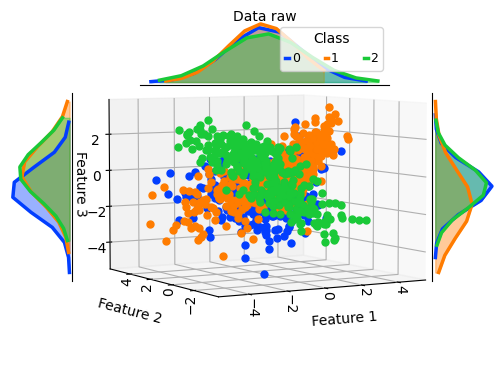

In [334]:
# data=data[:,0:2]
plot_features(data, labels, fig_size=(4, 3), title="Data raw")

In [ ]:
ax2.spines[['top', 'right', 'bottom']].set_visible(False)
ax2.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

ax.grid(visible="on")
ax.set_xlabel('Feature 1', labelpad=3, fontsize=10, va='center')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
ax.tick_params(axis='y', width=0, which="major", bottom=False, top=False, labelbottom=True, labeltop=True, pad=-4, rotation=45)

ax1.spines[['top', 'left', 'right']].set_visible(False)   
ax1.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
ax1.legend(title='Class', loc="best", ncol=3, handlelength=0.3, handletextpad=0.2, fontsize=9)  # bbox_to_anchor=(0.1, pos1.x1-0.02, pos1.x1-0.02, 0)

plt.autoscale(enable=True, axis="x",tight=True)
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, wspace=0, hspace=0)
ax1.set_title("title", fontsize=10, pad=0, y=1)
# pos1 = ax1.get_position()
# fig.suptitle("title", fontsize=10, x=0.4, y=pos1.y1)
# print(pos1)
       
  
ax2.spines[['top', 'right', 'bottom']].set_visible(False)
ax2.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

**1. Load data**

In [257]:
method = 1
if method==1:
   x, y = datasets.make_classification(n_samples=1000,      # Number of samples in the dataset
                                       n_features=5,       # Number of total features
                                       n_informative=4,    # Number of informative features
                                       n_redundant=0,      # Number of redundant features
                                       n_classes=3,        # Number of classes in the dataset (binary classification in this case)
                                       random_state=1)     # Seed for reproducibility)
   # print(f"{x.shape=},\n{x=},\n{y=}")
elif method==2:
   iris = datasets.load_iris()
   x = iris.data
   y = iris.target
   # print(f"{iris.data.shape=},\n{iris.feature_names=},\n{iris.target_names=},\n{iris.data=},\n{iris.target}")

**2. Preparing the data**

<Figure size 400x300 with 0 Axes>

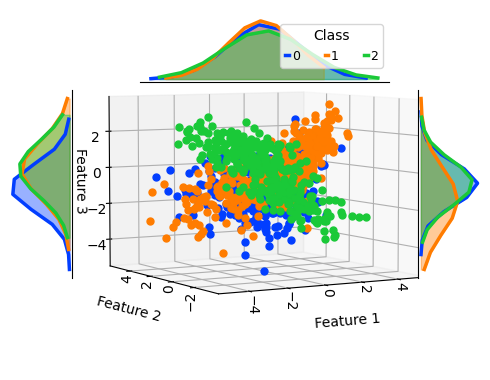

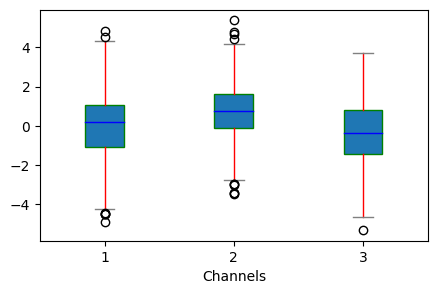

In [301]:
data, labels = preparing_data(x, y)
data=data[:,0:3]

plot_features(data, labels, fig_size=(4, 3), title="Data raw")
# ------------------------------------------------------ Boxplot -------------------------------------------------------------
plt.figure(figsize=(5, 3))
plt.boxplot(data, boxprops=dict(color='green'), whiskerprops=dict(color='red'), medianprops=dict(color='blue'), capprops=dict(color='gray'), patch_artist=True)
plt.xlabel("Channels");

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Set the figure size
fig = plt.figure(figsize=(5, 5))

# Create a 4x4 grid for subplots with reduced spacing
gs = plt.GridSpec(4, 4, hspace=0.1, wspace=0.1)

# Create the first subplot (top left)
ax1 = plt.subplot(gs[0, 0])
ax1.set_title('Plot 1')
ax1.plot(np.arange(10), np.random.rand(10))

# Create the second subplot (top right)
ax2 = plt.subplot(gs[0, 1])
ax2.set_title('Plot 2')
ax2.plot(np.arange(10), np.random.rand(10))

# Create the third subplot (bottom left)
ax3 = plt.subplot(gs[1:, 0])
ax3.set_title('Plot 3')
ax3.plot(np.arange(10), np.random.rand(10))

# Create the fourth subplot (bottom right) as a 3D plot
ax4 = plt.subplot(gs[1:, 1:], projection='3d')
ax4.set_title('3D Plot')
x = np.linspace(0, 5, 100)
y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))
ax4.plot_surface(X, Y, Z, cmap='viridis')

# Adjust layout to prevent clipping of titles
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

In [ ]:
mean = [0, 0]
cov = [[1, 1], [1, 2]]
x, y = np.random.multivariate_normal(mean, cov, 3000).T

# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 5))
grid = plt.GridSpec(7, 5, hspace=0.05, wspace=0.05)

ax = fig.add_subplot(grid[1:, :4], projection="3d")
ax1 = fig.add_subplot(grid[1, 1:3], yticklabels=[])
# ax2 = fig.add_subplot(grid[1:, 3], xticklabels=[], sharey=ax)
# ax3 = fig.add_subplot(grid[1:, 3], xticklabels=[], sharey=ax)

Bbox(x0=0.09999999999999994, y0=-0.05, x1=0.8200000000000001, y1=0.85) Bbox(x0=0.22, y0=0.67, x1=0.74, y1=0.8300000000000001) Bbox(x0=0.8, y0=0.17, x1=0.93, y1=0.63) Bbox(x0=-0.05, y0=0.19, x1=0.08, y1=0.65)


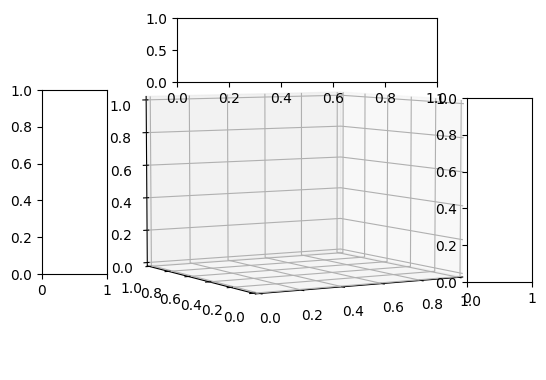

In [59]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes((0.05, -0.05, 0.82, 0.9), projection="3d")
ax1 = fig.add_axes((0.22, 0.67, 0.52, 0.16))
ax2 = fig.add_axes((0.8, 0.17, 0.13, 0.46))
ax3 = fig.add_axes((-0.05, 0.19, 0.13, 0.46))
ax.view_init(5, -120)
print(ax.get_position(), ax1.get_position(), ax2.get_position(), ax3.get_position())

In [ ]:
grid = plt.GridSpec(4, 4, hspace=0.05, wspace=0.05)
ax = fig.add_subplot(grid[1:, 1:3], projection="3d")
ax1 = fig.add_subplot(grid[0, 1:3], yticklabels=[], sharex=ax)
ax2 = fig.add_subplot(grid[1:, 3], xticklabels=[], sharey=ax)
ax3 = fig.add_subplot(grid[1:, 0:1], xticklabels=[], sharey=ax)

ax_pos = ax.get_position()      # Set the positions for the subplots
ax1_pos = ax1.get_position()
ax2_pos = ax2.get_position()
ax3_pos = ax3.get_position()

ax.set_position([ax_pos.x0, ax_pos.y0, ax_pos.width * 0.8, ax_pos.height])
ax1.set_position([ax1_pos.x0, ax1_pos.y0, ax1_pos.width, ax1_pos.height])
ax2.set_position([ax2_pos.x0, ax2_pos.y0, ax2_pos.width, ax2_pos.height])
ax3.set_position([ax3_pos.x0, ax3_pos.y0, ax3_pos.width, ax3_pos.height])

print(ax.get_position(), ax1.get_position(), ax2.get_position(), ax3.get_position())

Bbox(x0=0.05, y0=0.058333333333333334, x1=0.87, y1=0.7416666666666667),
 Bbox(x0=0.09, y0=0.7416666666666667, x1=0.79, y1=0.8783333333333334),
 ax_pos.width=0.82, 
 ax1_pos.width=0.65, 
 ax_pos.height=0.6833333333333333
ax_pos.x0=0.05


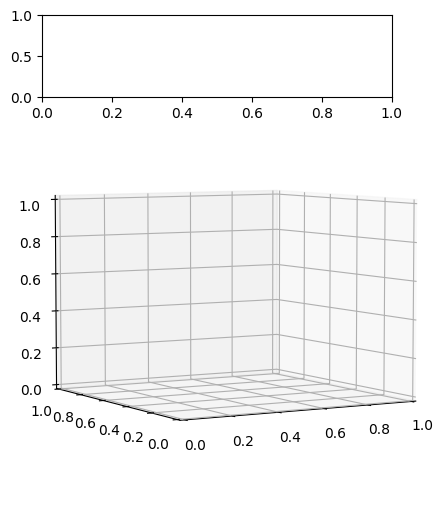

In [255]:
# from mpl_toolkits.mplot3d import Axes3D
fig_size = [5, 6]
fig = plt.figure(figsize=fig_size)
fig.subplots_adjust(wspace=0, hspace=0)
ax = fig.add_axes((0.05, -0.05, 0.82, 0.9), projection="3d")
ax1 = fig.add_axes((0.22, 0.67, 0.52, 0.16))
# ax2 = fig.add_axes((0.8, 0.18, 0.13, 0.47))
# ax3 = fig.add_axes((-0.05, 0.18, 0.13, 0.47))
ax.view_init(5, -120)
ax_pos = ax.get_position()           # Set the positions for the subplots
# ax1_pos = ax1.get_position()
if fig_size[0] >= fig_size[1]:
   ax1.set_position([ax_pos.x0+0.04, 0.67, ax_pos.width-0.05, 0.16])
else:
   ax1.set_position([ax_pos.x0+0.04, ax_pos.y1, ax1_pos.width+0.05, 0.2*ax_pos.height])
# # ax1_pos.y0=ax_pos.y0
# ax1_pos.x1=ax_pos.x1

# # ax2_pos = ax2.get_position()
# # ax3_pos = ax3.get_position()
# ax.set_position([ax_pos.x0, ax_pos.y0, ax1_pos.width * 0.8, ax1_pos.height])
# ax1.set_position([ax_pos.x0, 0.57, ax_pos.width-0.03, 0.16])
# ax2.set_position([ax_pos.x1, ax2_pos.y0, ax2_pos.width, ax2_pos.height])
# ax3.set_position([ax_pos.x0, ax3_pos.y0, ax3_pos.width, ax3_pos.height]), 
# print(f"{ax.get_position()},\n {ax1.get_position()},\n {ax_pos.width=},\n{ax1_pos.width=}\n{np.min((ax_pos.width, ax1_pos.width))=}")
# print(ax.get_position(), ax1.get_position(), ax_pos.width, ax_pos.height)
print(f"{ax.get_position()},\n {ax1.get_position()},\n {ax_pos.width=}, \n {ax1_pos.width=}, \n {ax_pos.height=}\n{ax_pos.x0=}")
# print(fig.gca())
# print(fig.axes[0])
# print(fig.axes[1])
# print(fig.axes[2])
# print(fig.axes[3])


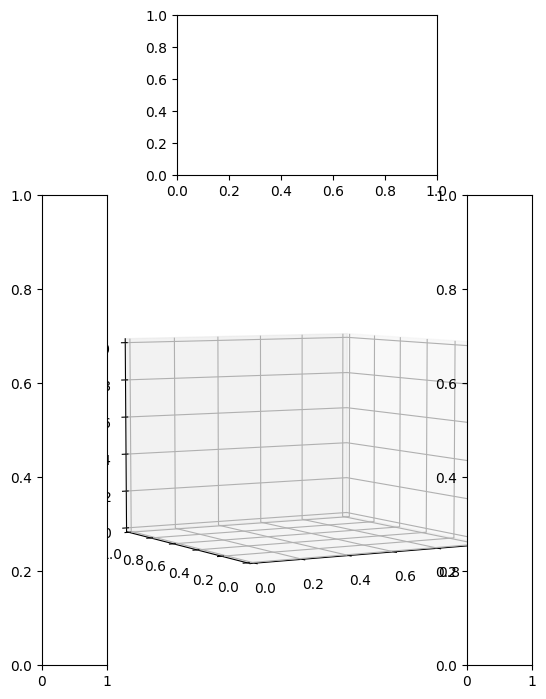

In [135]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 4))

# Adjust subplot parameters to remove extra space
fig.subplots_adjust(wspace=0, hspace=0)

ax = fig.add_axes((0.05, -0.05, 0.82, 0.9), projection="3d")
ax1 = fig.add_axes((0.22, 0.67, 0.52, 0.16))
ax2 = fig.add_axes((0.8, 0.18, 0.13, 0.47))
ax3 = fig.add_axes((-0.05, 0.18, 0.13, 0.47))

ax.view_init(5, -120)

plt.show()


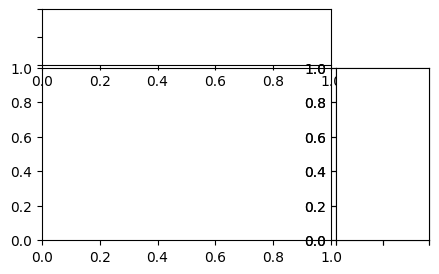

In [5]:


lab = np.unique(labels)
colors = np.array(sns.color_palette("bright", len(lab))) 
    
# for i in range(0, len(lab)):
   
#    ax.plot(data[labels == lab[i], 0], data[labels == lab[i], 1], '.', markersize=10, color=colors[i, :])
   
#    _, bins = np.histogram(data[labels == lab[i], 0], density=True)
#    ax1.plot(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), linewidth=1.5, color=colors[i, :], label=lab[i])
#    ax1.fill_between(bins, y1=stats.norm.pdf(bins, np.mean(data[labels == lab[i], 0]), np.std(data[labels == lab[i], 0])), y2=0, alpha=0.4)
   
#    _, bins = np.histogram(data[labels == lab[i], 1], density=True)
#    ax2.plot(stats.norm.pdf(bins, np.mean(data[labels == lab[i], 1]), np.std(data[labels == lab[i], 1])), bins, linewidth=2.5, color=colors[i, :])
#    ax2.fill_betweenx(bins, stats.norm.pdf(bins, np.mean(data[labels == lab[i], 1]), np.std(data[labels == lab[i], 1])), 0, alpha=0.4, color=colors[i, :])

# ax.set_ylabel('Feature 2', fontsize=10,labelpad=0, va='center')
# ax2.spines[['top', 'right', 'bottom']].set_visible(False)
# ax2.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

# ax.grid(visible="on")
# ax.set_xlabel('Feature 1', labelpad=3, fontsize=10, va='center')
# ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
# ax.tick_params(axis='y', width=0, which="major", bottom=False, top=False, labelbottom=True, labeltop=True, pad=-4, rotation=45)

# ax1.spines[['top', 'left', 'right']].set_visible(False)   
# ax1.tick_params(bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
# ax1.legend(title='Class', loc="best", ncol=3, handlelength=0.3, handletextpad=0.2, fontsize=9)  # bbox_to_anchor=(0.1, pos1.x1-0.02, pos1.x1-0.02, 0)

# plt.autoscale(enable=True, axis="x",tight=True)
# fig.subplots_adjust(top=1, bottom=0, left=0, right=1, wspace=0, hspace=0)
# ax1.set_title("title", fontsize=10, pad=0, y=1)
# # pos1 = ax1.get_position()
# # fig.suptitle("title", fontsize=10, x=0.4, y=pos1.y1)
# # print(pos1)

**3. Filtering**<br/>

`Fs > f_high > f_low`

In [6]:
filtered_data = filtering(data, f_low=3, f_high=10, order=3, fs=50, filter_type="low")    # btype:'low','high','bandpass','bandstop'
plot_data(filtered_data, fs=None, first_point=0, last_point=500, val_ylim=3, size_fig=(7,5), title='filtered_data', display_figure="off")

**4. Split data**

In [321]:
data=data[:,0:3]

In [322]:
data_train, data_test, label_train, label_test = model_selection.train_test_split(data, labels, test_size=0.3, random_state=42)

**5. Data normalization**

In [314]:
data_train, data_test = data_normalization(data_train, data_test, method=2)   # method 1: MinMaxScaler, method 2: StandardScaler

**6. Classification**<br/>

The advantages of support vector machines are:
- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.
- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
- Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

Decision Tree:
- def error(p):<br/>
    return 1 - np.max([p, 1 - p])
- def gini(p):<br/>
    return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))
- def entropy(p):<br/>
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

LR_train: 0.5257142857142857, LR_test: 0.5366666666666666
MLP_train: 0.5414285714285715, MLP_test: 0.5566666666666666
SVM_train: 0.5171428571428571, SVM_test: 0.5066666666666667
DT_train: 0.7257142857142858, DT_test: 0.6233333333333333
NB_train: 0.5357142857142857, Nb_test: 0.58
RF_train: 0.77, RF_test: 0.7166666666666667
AdaBoost_train: 0.6357142857142857, AdaBoost_test: 0.49666666666666665
XGBoost_train: 1.0, XGBoost_test: 0.7066666666666667
LDA_train: 0.5314285714285715, LDA_test: 0.54
KNN_train: 0.7357142857142858, KNN_test: 0.7633333333333333


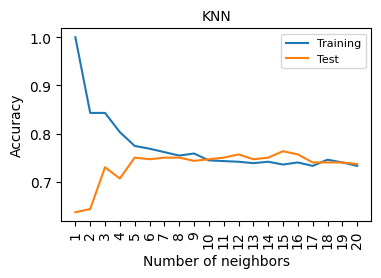

In [830]:
# ------------------------------------------------ Logistic Regression ----------------------------------------------------
model = linear_model.LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial', penalty='l2') # sag, newton-c,lbfg;  penalty='l2', Nonr
model.fit(data_train, label_train)

y_pred_train = model.predict(data_train) 
y_pred_test = model.predict(data_test)    #predict model
print(f"LR_train: {model.score(data_train, label_train)}, LR_test: {model.score(data_test, label_test)}")

# ------------------------------------------------------- MLP -------------------------------------------------------------
model = neural_network.MLPClassifier(hidden_layer_sizes=(8), max_iter=1000, alpha=1e-4, learning_rate='invscaling', solver='sgd',
                                     random_state=1, learning_rate_init=0.05, verbose=False , tol=1e-4)    # {'adam', 'sgd', 'lbfgs'}
model.fit(data_train, label_train)
y_pred_train = model.predict(data_train) 
y_pred_test = model.predict(data_test)    #predict model
print(f"MLP_train: {model.score(data_train, label_train)}, MLP_test: {model.score(data_test, label_test)}")

# ------------------------------------------------------- SVM -------------------------------------------------------------
kernel_svm = "linear"   # poly, rbf, sigmoid, precomputed, if 'poly'---> degree=3
# c ---> Regularization parameter

model = svm.SVC(kernel=kernel_svm, random_state=0, C=10, gamma="auto", probability=True) 
model.fit(data_train, label_train)
model.support_vectors_
model.support_      # get indices of support vectors
model.n_support_  # get number of support vectors for each class
y_pred_train = model.predict(data_train) 
y_pred_test = model.predict(data_test)    #predict model
print(f"SVM_train: {model.score(data_train, label_train)}, SVM_test: {model.score(data_test, label_test)}")

# -------------------------------------------------------- DT -------------------------------------------------------------
criterion_dt = "gini"                   #  gini, entropy, log_loss
model = tree.DecisionTreeClassifier(criterion=criterion_dt, max_depth=5, random_state=0)
model.fit(data_train, label_train)
y_pred_train = model.predict(data_train) 
y_pred_test = model.predict(data_test)    #predict model
print(f"DT_train: {model.score(data_train, label_train)}, DT_test: {model.score(data_test, label_test)}")

# -------------------------------------------------------- NB -------------------------------------------------------------
model = naive_bayes.GaussianNB()
model.fit(data_train, label_train)
y_pred_train = model.predict(data_train) 
y_pred_test = model.predict(data_test)    #predict model
print(f"NB_train: {model.score(data_train, label_train)}, Nb_test: {model.score(data_test, label_test)}") 

# -------------------------------------------------------- RF -------------------------------------------------------------       
model = ensemble.RandomForestClassifier(n_estimators=500, max_depth=5, criterion=criterion_dt, random_state=0)
model.fit(data_train, label_train)
y_pred_train = model.predict(data_train) 
y_pred_test = model.predict(data_test)    #predict model
print(f"RF_train: {model.score(data_train, label_train)}, RF_test: {model.score(data_test, label_test)}") 

# ---------------------------------------------------- AdaBoost -----------------------------------------------------------  
 # model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
# model = ensemble.AdaBoostClassifier(base_estimator=model, n_estimators=100, random_state=0)
model = ensemble.AdaBoostClassifier(n_estimators=500, learning_rate=0.9, random_state=0)
model.fit(data_train, label_train)
y_pred_train = model.predict(data_train) 
y_pred_test = model.predict(data_test)    #predict model
print(f"AdaBoost_train: {model.score(data_train, label_train)}, AdaBoost_test: {model.score(data_test, label_test)}") 

# ------------------------------------------------------ XGBoost ----------------------------------------------------------  
model = XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.08, random_state=0, objective='multi:softprob')
model.fit(data_train, label_train)
y_pred_train = model.predict(data_train) 
y_pred_test = model.predict(data_test)    #predict model
print(f"XGBoost_train: {model.score(data_train, label_train)}, XGBoost_test: {model.score(data_test, label_test)}") 

# -------------------------------------------------------- LDA ------------------------------------------------------------  
model = discriminant_analysis.LinearDiscriminantAnalysis(n_components=len(np.unique(labels)) - 1)
model.fit(data_train, label_train)
y_pred_train = model.predict(data_train) 
y_pred_test = model.predict(data_test)    #predict model
print(f"LDA_train: {model.score(data_train, label_train)}, LDA_test: {model.score(data_test, label_test)}") 

# -------------------------------------------------------- LDA ------------------------------------------------------------  
num_k = knn_optimal(data_train, label_train, data_test, label_test, n=21, fig_size=(4,2.5))  # Obtain optimal K
model = neighbors.KNeighborsClassifier(n_neighbors=num_k, metric='minkowski')
model.fit(data_train, label_train)
y_pred_train = model.predict(data_train) 
y_pred_test = model.predict(data_test)    #predict model
print(f"KNN_train: {model.score(data_train, label_train)}, KNN_test: {model.score(data_test, label_test)}") 

In [ ]:
type_class = "Logistic Regression"
k_fold = 5

if data_train.shape[1] == 2:
        plot_classification(data_train, label_train, data_test, label_test, model, type_class, position_title=0.08, fig_size=(3, 2))
        
elif np.shape(data_train)[1] > 2:
        x_train = data_train[:, 0:3]
        x_test = data_test[:, 0:3]
        lab = np.unique(label_train)
        fig = plt.figure(figsize=(5, 3))
        # fig, axs= plt.subplots(nrows=1, ncols=2,)
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')

        for i in range(0, len(lab)):
            ax1.plot3D(x_train[y_pred_train == lab[i], 0], x_train[y_pred_train == lab[i], 1], x_train[y_pred_train == lab[i], 2], '.')
            ax2.plot3D(x_test[y_pred_test == lab[i], 0], x_test[y_pred_test == lab[i], 1], x_test[y_pred_test == lab[i], 2], '.')
        
        ax1.view_init(5, -120), ax2.view_init(5, -120)    
        # ax1.title.set_text('Training'), ax1.set_xlabel('Feature 1'), ax1.set_ylabel('Feature 2'), ax1.set_zlabel('Feature 3'),
        # ax1.legend(lab, title='Class', ncol=3, handlelength=0.8, handletextpad=0.2), ax2.legend(lab, title='Class', ncol=3, handlelength=0.8, handletextpad=0.2)
        # , ax2.title.set_text('Test'), ax2.set_xlabel('Feature 1'), ax2.set_ylabel('Feature 2'), ax2.set_zlabel('Feature 3'),
        # pos1 = ax2.get_position()
        # fig.suptitle('Classification Type: ' + type_class+'; '+str(k_fold)+'th K-fold:', fontsize=12, y=pos1.x1), fig.show()
        
        ax1.set_xlabel('Feature 1', labelpad=-1, fontsize=10, va='center'), ax2.set_xlabel('Feature 1', labelpad=-1, fontsize=10, va='center')
        ax1.set_ylabel('Feature 2', labelpad=-1, fontsize=10, va='center'), ax2.set_ylabel('Feature 2', labelpad=-1, fontsize=10, va='center')
        ax1.set_zlabel('Feature 3', labelpad=-6, fontsize=10, va='center'), ax2.set_zlabel('Feature 3', labelpad=-6, fontsize=10, va='center')
        
        ax1.tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=-4)
        ax2.tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=-4)
        ax1.tick_params(axis='y', length=2, width=1, which="both", bottom=True, top=False, labelbottom=True, labeltop=True, pad=-4, rotation=45)
        ax2.tick_params(axis='y', length=2, width=1, which="both", bottom=True, top=False, labelbottom=True, labeltop=True, pad=-4, rotation=45)
        ax1.tick_params(axis='z', length=2, width=1, which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
        ax2.tick_params(axis='z', length=2, width=1, which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
        
        
#       ax.margins(x=0), ax.margins(y=0), ax.margins(z=0)

#    pos1 = ax1.get_position()
#    fig.suptitle(title, fontsize=10, y=pos1.y0 + 0.2)

#    ax1.legend(title='Class', loc="best", ncol=3, handlelength=0.09, handletextpad=0.3, fontsize=8)  # bbox_to_anchor=(0.1, pos1.x1-0.02, pos1.x1-0.02, 0)
#    fig.subplots_adjust(top=1, bottom=0, left=0, right=1, wspace=0, hspace=0)
        
#     axs[0].set_title('Training', loc='left', pad=0, fontsize=10), axs[1].set_xlabel('Feature 1',  fontsize=10, va='center')
#     axs[1].set_title('Test', loc='right', pad=0, fontsize=10), axs[0].legend(title='Class', ncol=3, handlelength=-0.1, handletextpad=0.3)
    
#     fig.suptitle(type_class, fontsize=11,x=0.51,  y=1+position_title, fontweight='normal', color='black', va='top')
        plt.subplots_adjust(top=0, bottom=-1, left=-1, right=0, wspace=0.02, hspace=0), plt.autoscale(enable=True, axis="x", tight=True)

In [ ]:

def plot_classifier(data_train, label_train, data_test, label_test, label_predict_train, label_predict_test, k_fold,  model, type_class):
    if np.shape(data_train)[1] == 2:
        plot_decision_regions(data_train, label_train, data_test, label_test, model, type_class)
    elif np.shape(data_train)[1] == 3:
        lab_tr = np.unique(label_train)
        fig = plt.figure(figsize=(8, 5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')

        for i in range(0, len(lab_tr)):
            ax1.plot3D(data_train[label_predict_train == lab_tr[i], 0], data_train[label_predict_train == lab_tr[i], 1], data_train[label_predict_train == lab_tr[i], 2], '.')
            ax2.plot3D(data_test[label_predict_test == lab_tr[i], 0], data_test[label_predict_test == lab_tr[i], 1], data_test[label_predict_test == lab_tr[i], 2], '.')
        ax1.title.set_text('Training'), ax1.set_xlabel('Feature 1'), ax1.set_ylabel('Feature 2'), ax1.set_zlabel('Feature 3'),
        ax1.legend(lab_tr, title='Class', ncol=3, handlelength=0.8, handletextpad=0.2), ax2.legend(lab_tr, title='Class', ncol=3, handlelength=0.8, handletextpad=0.2)
        ax1.view_init(30, 60), ax2.view_init(30, 60), ax2.title.set_text('Test'), ax2.set_xlabel('Feature 1'), ax2.set_ylabel('Feature 2'), ax2.set_zlabel('Feature 3'),
        pos1 = ax2.get_position()
        fig.suptitle('Classification Type: ' + type_class+'; '+str(k_fold)+'th K-fold:', fontsize=12, y=pos1.x1), fig.show()


In [ ]:

from sklearn import datasets
from Filtering import filtering
from Clustering import clustering
from Preparing_data import preparing_data
from Normalize import normalize_data
from Classification import classification
from Plot_clustering import plot_cluster
from Feature_Selection import featureselection
from Feature_Extraction import feature_extraction
from Output_Training_Test_Network import output_network


# ======================================= Step 3: Feature Extraction & Selection =======================================
# Data = feature_extraction(Data, Labels, number_feature=3, number_neighbors=70, type_feature='LDA')
# Data = featureselection(Data, Labels, threshold=0.1, number_feature=3, c_l1fs=0.01, n_estimators_tfs=100,  type_feature='MI')
"""
Feature Extraction:
PCA:Principal Component Analysis; LDA:Linear discriminant analysis; ICA: Independent component analysis; SVD: Singular value decomposition
TSNE:T-distributed stochastic neighbor embedding; FA: Factor analysis; Isomap: Isometric Feature Mapping
Feature Selection:
Variance; Mutual information (MI); Chi-square test (Chi-square); fisher_score (FS); Forward feature selection (FFS);
Backward feature selection (BFS); Exhaustive Feature Selection (EFS); Recursive feature elimination (RFE); Random Forest (RF)
Univariate feature selection (UFS); L1-based feature selection (L1FS), Tree-based feature selection (TFS)
"""
# ===================================== Step 4: Classification & Clustering ==========================================
# ----------------------------------------- Step 4: Classification ---------------------------------------------------

Accuracy_Train, Cr_Train, Accuracy_Test, Cr_Test = output_network(Data, Labels, model, type_class, k_fold=5)
"""
type_class: 'KNN', 'LR', 'MLP', 'SVM', 'DT', 'NB', 'RF', 'AdaBoost', 'XGBoost', 'LDA'

LR: LogisticRegression; MLP: Multilayer perceptron, SVM:Support Vector Machine; DT: Decision Tree; NB: Naive Bayes;
RF: Random Forest; AdaBoost; XGBoost; LDA: Linear Discriminant Analysis; KNN:K-Nearest Neighbors 
Parameters:
The number of hidden layers: hidden_layer_mlp; The number of epochs MLP: max_iter,

max_depth=The maximum depth of the tree, random forest and XGBoost;;
n_estimators:The number of trees in the forest.
"""
# ----------------------------------------- Step 4: Clustering -----------------------------------------------------
clustering(Data, n_clusters=3, max_iter=100, thr_brich=0.5,  branchfactor_brich=50, n_neighbor_SpecCluster=10,
           minsamples_optics=15, max_dist_optics=5, batch_size_MBKmeans=10, type_cluster='MiniBatchKMeans')
"""
type_cluster: kmeans; Agglomerative; DBSCAN; GMM:Gaussian Mixture Models; Meanshift; Birch; SpectralClustering; 
OPTICS; MiniBatchKMeans
"""


In [ ]:


def classification(data, labels, type_class, hidden_layer_mlp, max_iter, kernel_svm, c_svm, gamma_svm, max_depth, criterion_dt, n_estimators):
   

   
    return model, type_class

In [ ]:
x = np.random.randn(1000)
y = np.random.randn(1000)

left, width = 0.1, 0.65
bottom= 0.1
width = 0.65
height =0.65
bottom_h =  left+width+0.02
left_h   = left+width+0.02

rect_scatter = [left, bottom, width, height]
rect_histx   = [left, bottom_h, width, 0.2]
rect_histy   = [left_h, bottom, 0.2, height] 
plt.figure(1, figsize=(8,8))
axScatter = plt.axes(rect_scatter)
axHistx   = plt.axes(rect_histx)
axHisty   = plt.axes(rect_histy)

plt.figure(1, figsize=(8,8))
axScatter = plt.axes(rect_scatter)
axHistx   = plt.axes(rect_histx)
axHisty   = plt.axes(rect_histy)

axScatter.scatter(x, y,c='r')

binwidth = 0.25
xymax = np.max( [np.max(np.fabs(x)), np.max(np.fabs(y))] )
lim = ( int(xymax/binwidth) + 1) * binwidth
axScatter.set_xlim( (-lim, lim) )
axScatter.set_ylim( (-lim, lim) )
bins = np.arange(-lim, lim + binwidth, binwidth)

axHistx.hist(x, bins=bins,color='green')

axHisty.hist(y, bins=bins, orientation='horizontal',color='b')

axHistx.set_xlim( axScatter.get_xlim() );
axHisty.set_ylim( axScatter.get_ylim() );

In [ ]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.8)